In [5]:
%load_ext jupyter_black
import torch
import torch.optim as optim
import torch.nn as nn
from optimizers.lsgd import LSGD
from optimizers.lrmsprop import LRMSprop
from optimizers.ladam import LAdam
from optimizers.ladadelta import LAdadelta
from optimizers.lsgd import APLSGD
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import tqdm
import math
from training.train import train, plot_langevin_loss
from diffusion.oil_drilling import OilDrilling
from scheduler import PiecewiseConstantScheduler

plt.style.use(["science", "no-latex", "grid"])

seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [6]:
train_batch = 512
test_batch = 512
train_size = 5
test_size = 25

### Single control:

In [7]:
def test_diag_single_ctrl(
    model_config,
    N_euler,
    control_config,
    optim,
    langevin_optim,
    name,
    lr,
    target_lr,
    sigma,
    epochs,
    total_iters,
    **optim_kwargs,
):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

    for i, N in enumerate(N_euler):
        # Vanilla algo
        ocp = OilDrilling(**model_config, N_euler=N)
        ocp.set_control(control_config, multiple_controls=False)
        vanilla_optim = optim(ocp.control.parameters(), lr=lr, **optim_kwargs)
        scheduler = PiecewiseConstantScheduler(
            vanilla_optim, target_lr=target_lr, target_sigma=0, total_iters=total_iters
        )
        train_loss, test_loss, test_ci = train(
            ocp,
            vanilla_optim,
            scheduler,
            name,
            epochs,
            train_size,
            test_size,
            train_batch,
            test_batch,
        )
        axs[i].plot(
            np.arange(len(test_loss)), test_loss, marker="o", mec="k", ms=3, label=name
        )
        axs[i].fill_between(
            np.arange(len(test_loss)),
            np.array(test_loss) - np.array(test_ci),
            np.array(test_loss) + np.array(test_ci),
            alpha=0.2,
        )

        # Langevin algo
        ocp = OilDrilling(**model_config, N_euler=N)
        ocp.set_control(control_config, multiple_controls=False)
        loptim = langevin_optim(ocp.control.parameters(), lr=lr, sigma=sigma[i])
        scheduler = PiecewiseConstantScheduler(
            loptim, target_lr=target_lr, target_sigma=0, total_iters=total_iters
        )
        train_loss, test_loss, test_ci = train(
            ocp,
            loptim,
            scheduler,
            f"L-{name}",
            epochs,
            train_size,
            test_size,
            train_batch,
            test_batch,
        )
        axs[i].plot(
            np.arange(len(test_loss)),
            test_loss,
            marker="o",
            mec="k",
            ms=3,
            label=f"L-{name}",
        )
        axs[i].fill_between(
            np.arange(len(test_loss)),
            np.array(test_loss) - np.array(test_ci),
            np.array(test_loss) + np.array(test_ci),
            alpha=0.2,
        )

        if i == 0:
            axs[i].set_ylabel(r"$J(u_\theta)$")
        axs[i].set_xlabel("Epochs")
        if i == 2:
            legend = axs[i].legend(fancybox=True, edgecolor="k", loc=0)
            legend.get_frame().set_linewidth(0.5)

    plt.show()
    plt.close()

    return fig

In [8]:
dim = 1
p_0 = 1

model_config = dict(
    T=1.0,
    dim=dim,
    mu=0.01,
    sigma=0.2,
    rho=0.01,
    epsilon=0.0,
    xi_s=0.005,
    K0=5.0,
    xi_e=0.01,
    qS=10.0,
    P0=p_0 * torch.ones(dim),
    U=(lambda x: x),
)

control_config = dict(
    input_dim=1 + 3 * dim,
    output_dim=3 * dim,
    hidden_dim=32,
    depth=2,
    activation=nn.ReLU(),
    out_transform=nn.ReLU(),
    dropout=0.2,
)

Oil Drilling: Epoch 79, Adam, lr=0.000, sigma=0.000, train=-0.203, test=-0.202: 100%|██████████| 80/80 [00:19<00:00,  4.14it/s]
Oil Drilling: Epoch 79, L-Adam, lr=0.000, sigma=0.000, train=-0.186, test=-0.175: 100%|██████████| 80/80 [00:19<00:00,  4.08it/s]
Oil Drilling: Epoch 79, Adam, lr=0.000, sigma=0.000, train=-0.178, test=-0.178: 100%|██████████| 80/80 [00:32<00:00,  2.48it/s]
Oil Drilling: Epoch 79, L-Adam, lr=0.000, sigma=0.000, train=-0.208, test=-0.209: 100%|██████████| 80/80 [00:33<00:00,  2.36it/s]
Oil Drilling: Epoch 79, Adam, lr=0.000, sigma=0.000, train=-0.208, test=-0.210: 100%|██████████| 80/80 [01:04<00:00,  1.24it/s]
Oil Drilling: Epoch 79, L-Adam, lr=0.000, sigma=0.000, train=-0.205, test=-0.202: 100%|██████████| 80/80 [01:02<00:00,  1.27it/s]


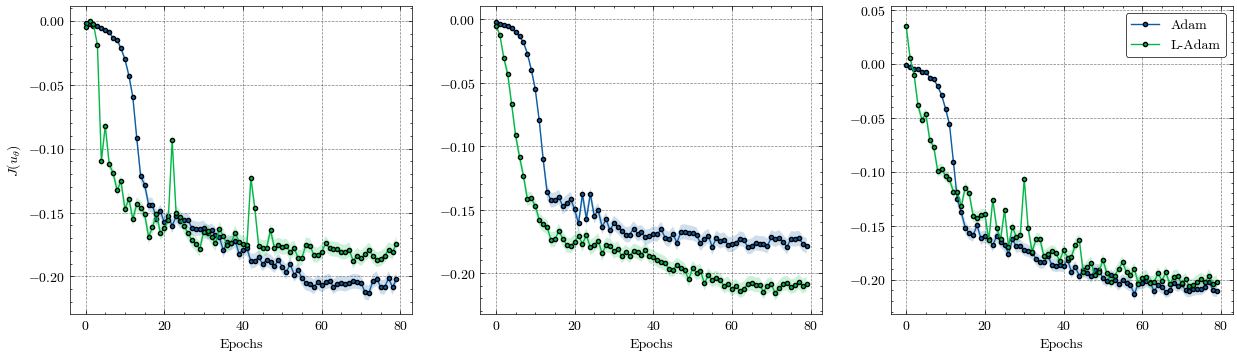

In [9]:
adam_single_ctrl = test_diag_single_ctrl(
    model_config,
    [30, 50, 100],
    control_config,
    torch.optim.Adam,
    LAdam,
    "Adam",
    2e-3,
    2e-4,
    [1e-3, 1e-3, 1e-3],
    80,
    60,
)

Oil Drilling: Epoch 99, RMSprop, lr=0.000, sigma=0.000, train=-0.205, test=-0.192: 100%|██████████| 100/100 [00:22<00:00,  4.47it/s]
Oil Drilling: Epoch 99, L-RMSprop, lr=0.000, sigma=0.000, train=-0.227, test=-0.216: 100%|██████████| 100/100 [00:22<00:00,  4.49it/s]
Oil Drilling: Epoch 99, RMSprop, lr=0.000, sigma=0.000, train=-0.206, test=-0.211: 100%|██████████| 100/100 [00:37<00:00,  2.64it/s]
Oil Drilling: Epoch 99, L-RMSprop, lr=0.000, sigma=0.000, train=-0.213, test=-0.223: 100%|██████████| 100/100 [00:41<00:00,  2.43it/s]
Oil Drilling: Epoch 99, RMSprop, lr=0.000, sigma=0.000, train=-0.175, test=-0.187: 100%|██████████| 100/100 [01:24<00:00,  1.18it/s]
Oil Drilling: Epoch 99, L-RMSprop, lr=0.000, sigma=0.000, train=-0.235, test=-0.227: 100%|██████████| 100/100 [01:24<00:00,  1.19it/s]


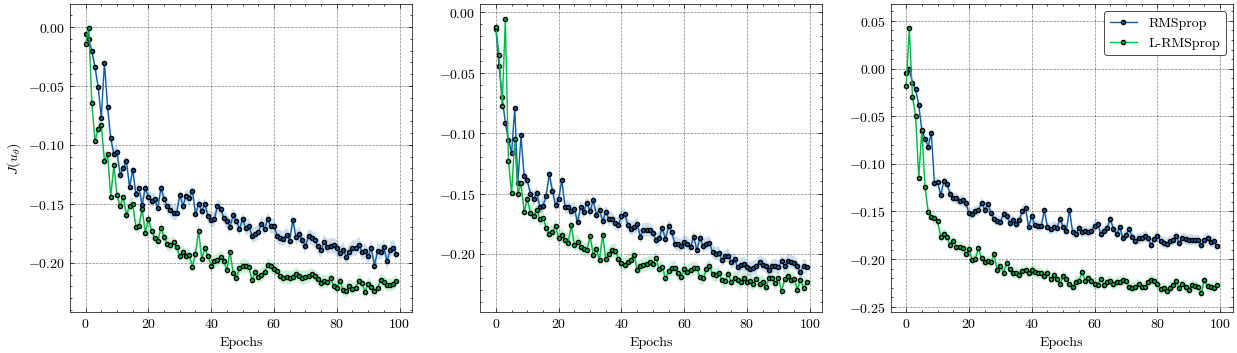

In [10]:
rmsprop_single_ctrl = test_diag_single_ctrl(
    model_config,
    [30, 50, 100],
    control_config,
    torch.optim.RMSprop,
    LRMSprop,
    "RMSprop",
    2e-3,
    2e-4,
    [2e-3, 2e-3, 2e-3],
    100,
    80,
)

Oil Drilling: Epoch 99, Adadelta, lr=0.050, sigma=0.000, train=-0.192, test=-0.198: 100%|██████████| 100/100 [00:23<00:00,  4.22it/s]
Oil Drilling: Epoch 99, L-Adadelta, lr=0.050, sigma=0.000, train=-0.200, test=-0.213: 100%|██████████| 100/100 [00:23<00:00,  4.20it/s]
Oil Drilling: Epoch 99, Adadelta, lr=0.050, sigma=0.000, train=-0.191, test=-0.188: 100%|██████████| 100/100 [00:42<00:00,  2.36it/s]
Oil Drilling: Epoch 99, L-Adadelta, lr=0.050, sigma=0.000, train=-0.215, test=-0.217: 100%|██████████| 100/100 [00:39<00:00,  2.51it/s]
Oil Drilling: Epoch 99, Adadelta, lr=0.050, sigma=0.000, train=-0.202, test=-0.210: 100%|██████████| 100/100 [01:22<00:00,  1.21it/s]
Oil Drilling: Epoch 99, L-Adadelta, lr=0.050, sigma=0.000, train=-0.219, test=-0.218: 100%|██████████| 100/100 [01:24<00:00,  1.19it/s]


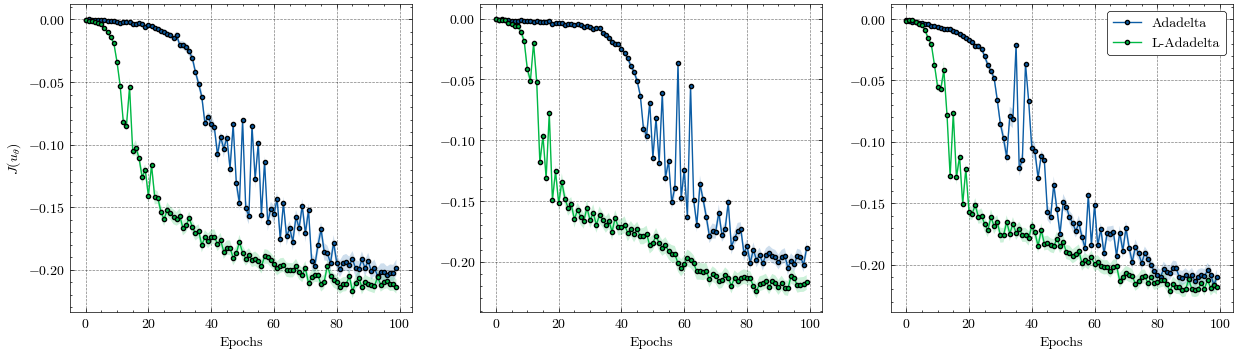

In [11]:
adadelta_single_ctrl = test_diag_single_ctrl(
    model_config,
    [30, 50, 100],
    control_config,
    torch.optim.Adadelta,
    LAdadelta,
    "Adadelta",
    5e-1,
    5e-2,
    [5e-3, 5e-3, 5e-3],
    100,
    80,
    rho=0.95,
)

Training Oil Drilling with SGD:   0%|          | 0/100 [00:00<?, ?it/s]

Oil Drilling: Epoch 99, SGD, lr=0.005, sigma=0.000, train=-0.214, test=-0.203: 100%|██████████| 100/100 [00:23<00:00,  4.17it/s]
Oil Drilling: Epoch 99, L-SGD, lr=0.005, sigma=0.000, train=-0.232, test=-0.234: 100%|██████████| 100/100 [00:22<00:00,  4.50it/s]
Oil Drilling: Epoch 99, SGD, lr=0.005, sigma=0.000, train=-0.221, test=-0.221: 100%|██████████| 100/100 [00:35<00:00,  2.85it/s]
Oil Drilling: Epoch 99, L-SGD, lr=0.005, sigma=0.000, train=-0.239, test=-0.233: 100%|██████████| 100/100 [00:32<00:00,  3.12it/s]
Oil Drilling: Epoch 99, SGD, lr=0.005, sigma=0.000, train=-0.184, test=-0.202: 100%|██████████| 100/100 [01:22<00:00,  1.21it/s]
Oil Drilling: Epoch 99, L-SGD, lr=0.005, sigma=0.000, train=-0.231, test=-0.231: 100%|██████████| 100/100 [01:17<00:00,  1.30it/s]


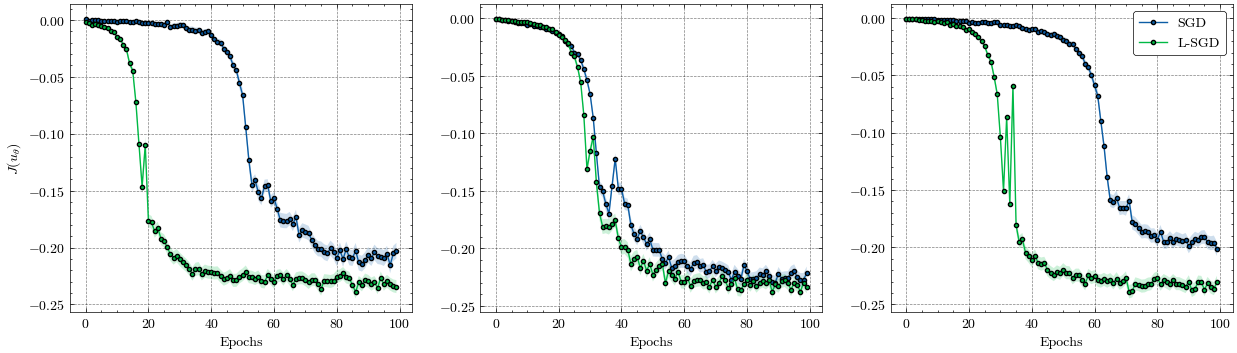

In [12]:
sgd_single_ctrl = test_diag_single_ctrl(
    model_config,
    [30, 50, 100],
    control_config,
    torch.optim.SGD,
    APLSGD,
    "SGD",
    5e-2,
    5e-3,
    [1e-3, 1e-3, 1e-3],
    100,
    80,
    momentum=0.9,
)

In [13]:
adam_single_ctrl.savefig("graphs/oil_drilling/adam_single_ctrl.pdf")
adadelta_single_ctrl.savefig("graphs/oil_drilling/adadelta_single_ctrl.pdf")
rmsprop_single_ctrl.savefig("graphs/oil_drilling/rmsprop_single_ctrl.pdf")
sgd_single_ctrl.savefig("graphs/oil_drilling/sgd_single_ctrl.pdf")

### Multiple controls:

In [25]:
dim = 1
p_0 = 1

model_config = dict(
    T=1.0,
    N_euler=10,
    dim=dim,
    mu=0.01,
    sigma=0.2,
    rho=0.01,
    epsilon=0.0,
    xi_s=0.005,
    K0=5.0,
    xi_e=0.01,
    qS=10.0,
    P0=p_0 * torch.ones(dim),
    U=(lambda x: x),
)

control_config = dict(
    input_dim=3 * dim,
    output_dim=3 * dim,
    hidden_dim=32,
    depth=2,
    activation=nn.ReLU(),
    out_transform=nn.ReLU(),
    dropout=0.2,
)

In [26]:
epochs = 80
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=True)
adam = [optim.Adam(control.parameters(), lr=2e-3) for control in ocp.control]

scheduler = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=60)
    for opt in adam
]

In [27]:
train_loss_adam, test_loss_adam, test_ci_adam = train(
    ocp,
    adam,
    scheduler,
    "Adam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Oil Drilling: Epoch 79, Adam, lr=0.000, sigma=[0], train=-0.181, test=-0.193: 100%|██████████| 80/80 [00:06<00:00, 12.15it/s]


In [28]:
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=True)
ladam = [LAdam(control.parameters(), lr=2e-3, sigma=2e-4) for control in ocp.control]

scheduler = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=60)
    for opt in ladam
]

In [29]:
train_loss_ladam, test_loss_ladam, test_ci_ladam = train(
    ocp,
    ladam,
    scheduler,
    "LAdam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Oil Drilling: Epoch 79, LAdam, lr=0.000, sigma=[0], train=-0.216, test=-0.202: 100%|██████████| 80/80 [00:07<00:00, 11.27it/s]     


In [30]:
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=True)
ll = 30
lladam = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        lladam.append(LAdam(control.parameters(), lr=2e-3, sigma=2e-4))
    else:
        lladam.append(optim.Adam(control.parameters(), lr=2e-3))


scheduler = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=60)
    for opt in lladam
]

In [31]:
train_loss_ll30_adam, test_loss_ll30_adam, test_ci_ll30_adam = train(
    ocp,
    lladam,
    scheduler,
    "LLAdam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Oil Drilling: Epoch 79, LLAdam, lr=0.000, sigma=[0], train=-0.205, test=-0.205: 100%|██████████| 80/80 [00:06<00:00, 11.97it/s]


In [32]:
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=True)
ll = 90
lladam = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        lladam.append(LAdam(control.parameters(), lr=2e-3, sigma=2e-4))
    else:
        lladam.append(optim.Adam(control.parameters(), lr=2e-3))


scheduler = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=60)
    for opt in lladam
]

In [33]:
train_loss_ll90_adam, test_loss_ll90_adam, test_ci_ll90_adam = train(
    ocp,
    lladam,
    scheduler,
    "LLAdam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Oil Drilling: Epoch 79, LLAdam, lr=0.000, sigma=[0], train=-0.217, test=-0.213: 100%|██████████| 80/80 [00:07<00:00, 11.32it/s]     


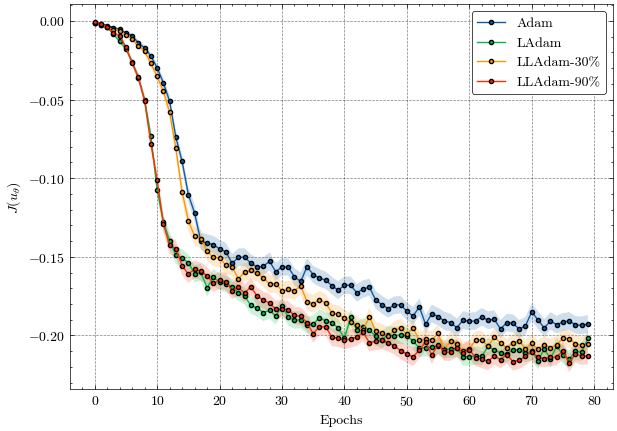

In [34]:
plot_langevin_loss(
    test_loss_adam,
    test_ci_adam,
    test_loss_ladam,
    test_ci_ladam,
    test_loss_llangevin=[test_loss_ll30_adam, test_loss_ll90_adam],
    test_ci_llangevin=[test_ci_ll30_adam, test_ci_ll90_adam],
    ll=[30, 90],
    name="Adam",
)

In [35]:
epochs = 100
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=True)
adadelta = [
    optim.Adadelta(control.parameters(), lr=5e-1, rho=0.95) for control in ocp.control
]

scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=5e-2, target_sigma=0, total_iters=80)
    for opt in adadelta
]

In [36]:
train_loss_adadelta, test_loss_adadelta, test_ci_adadelta = train(
    ocp,
    adadelta,
    scheduler,
    "Adadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Oil Drilling: Epoch 99, Adadelta, lr=0.000, sigma=[0], train=-0.007, test=-0.006: 100%|██████████| 100/100 [00:08<00:00, 12.35it/s]


In [37]:
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=True)
ladadelta = [
    LAdadelta(control.parameters(), lr=5e-1, sigma=5e-3) for control in ocp.control
]

scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=5e-2, target_sigma=0, total_iters=80)
    for opt in ladadelta
]

In [38]:
train_loss_ladadelta, test_loss_ladadelta, test_ci_ladadelta = train(
    ocp,
    ladadelta,
    scheduler,
    "LAdadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Oil Drilling: Epoch 99, LAdadelta, lr=0.000, sigma=[0], train=-0.190, test=-0.192: 100%|██████████| 100/100 [00:08<00:00, 11.53it/s]


In [39]:
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=True)
ll = 30
lladadelta = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        lladadelta.append(LAdadelta(control.parameters(), lr=5e-1, sigma=5e-3))
    else:
        lladadelta.append(optim.Adadelta(control.parameters(), lr=5e-1, rho=0.95))

scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=5e-2, target_sigma=0, total_iters=80)
    for opt in lladadelta
]

In [40]:
train_loss_ll30_adadelta, test_loss_ll30_adadelta, test_ci_ll30_adadelta = train(
    ocp,
    lladadelta,
    scheduler,
    "LLAdadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Oil Drilling: Epoch 99, LLAdadelta, lr=0.000, sigma=[0], train=-0.044, test=-0.047: 100%|██████████| 100/100 [00:08<00:00, 12.04it/s]


In [41]:
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=True)
ll = 90
lladadelta = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        lladadelta.append(LAdadelta(control.parameters(), lr=5e-1, sigma=5e-3))
    else:
        lladadelta.append(optim.Adadelta(control.parameters(), lr=5e-1, rho=0.95))

scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=5e-2, target_sigma=0, total_iters=80)
    for opt in lladadelta
]

In [42]:
train_loss_ll90_adadelta, test_loss_ll90_adadelta, test_ci_ll90_adadelta = train(
    ocp,
    lladadelta,
    scheduler,
    "LLAdadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Oil Drilling: Epoch 99, LLAdadelta, lr=0.000, sigma=[0], train=-0.196, test=-0.192: 100%|██████████| 100/100 [00:08<00:00, 11.66it/s]


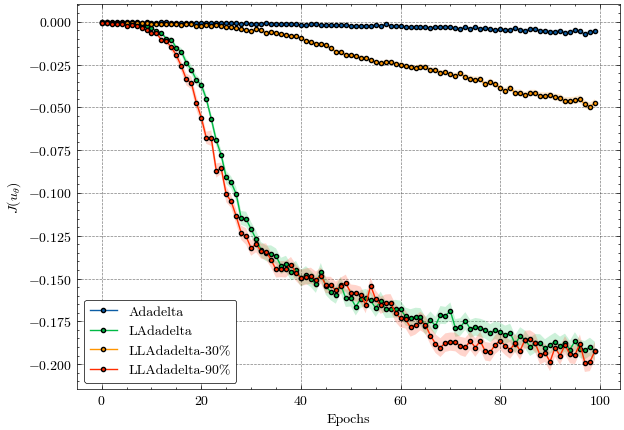

In [43]:
plot_langevin_loss(
    test_loss_adadelta,
    test_ci_adadelta,
    test_loss_ladadelta,
    test_ci_ladadelta,
    test_loss_llangevin=[test_loss_ll30_adadelta, test_loss_ll90_adadelta],
    test_ci_llangevin=[test_ci_ll30_adadelta, test_ci_ll90_adadelta],
    ll=[30, 90],
    name="Adadelta",
)

In [44]:
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=True)
rmsprop = [optim.RMSprop(control.parameters(), lr=2e-3) for control in ocp.control]

scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=80)
    for opt in rmsprop
]

In [45]:
train_loss_rmsprop, test_loss_rmsprop, test_ci_rmsprop = train(
    ocp,
    rmsprop,
    scheduler,
    "RMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Oil Drilling: Epoch 99, RMSprop, lr=0.000, sigma=[0], train=-0.191, test=-0.200: 100%|██████████| 100/100 [00:07<00:00, 12.72it/s]


In [46]:
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=True)
lrmsprop = [
    LRMSprop(control.parameters(), lr=2e-3, sigma=2e-3) for control in ocp.control
]

scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in lrmsprop
]

In [47]:
train_loss_lrmsprop, test_loss_lrmsprop, test_ci_lrmsprop = train(
    ocp,
    lrmsprop,
    scheduler,
    "LRMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Oil Drilling: Epoch 99, LRMSprop, lr=0.000, sigma=[0], train=-0.216, test=-0.219: 100%|██████████| 100/100 [00:08<00:00, 11.54it/s]


In [48]:
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=True)
ll = 30
llrmsprop = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        llrmsprop.append(LRMSprop(control.parameters(), lr=2e-3, sigma=2e-3))
    else:
        llrmsprop.append(optim.RMSprop(control.parameters(), lr=2e-3))

scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in llrmsprop
]

In [49]:
train_loss_ll30_rmsprop, test_loss_ll30_rmsprop, test_ci_ll30_rmsprop = train(
    ocp,
    llrmsprop,
    scheduler,
    "LLRMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Oil Drilling: Epoch 99, LLRMSprop, lr=0.000, sigma=[0], train=-0.199, test=-0.210: 100%|██████████| 100/100 [00:08<00:00, 12.35it/s]


In [50]:
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=True)
ll = 90
llrmsprop = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        llrmsprop.append(LRMSprop(control.parameters(), lr=2e-3, sigma=2e-3))
    else:
        llrmsprop.append(optim.RMSprop(control.parameters(), lr=2e-3))

scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in llrmsprop
]

In [51]:
train_loss_ll90_rmsprop, test_loss_ll90_rmsprop, test_ci_ll90_rmsprop = train(
    ocp,
    llrmsprop,
    scheduler,
    "LLRMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Oil Drilling: Epoch 99, LLRMSprop, lr=0.000, sigma=[0], train=-0.202, test=-0.214: 100%|██████████| 100/100 [00:08<00:00, 11.90it/s]


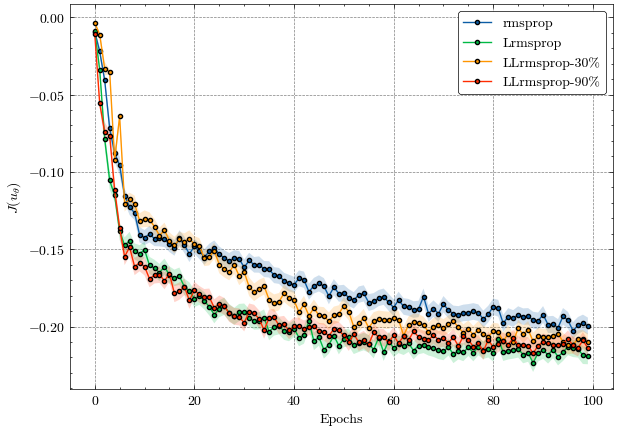

In [52]:
plot_langevin_loss(
    test_loss_rmsprop,
    test_ci_rmsprop,
    test_loss_lrmsprop,
    test_ci_lrmsprop,
    test_loss_llangevin=[test_loss_ll30_rmsprop, test_loss_ll90_rmsprop],
    test_ci_llangevin=[test_ci_ll30_rmsprop, test_ci_ll90_rmsprop],
    ll=[30, 90],
    name="rmsprop",
)

### Sample trajectory:

In [53]:
dim = 1
p_0 = 1

model_config = dict(
    T=1.0,
    N_euler=50,
    dim=dim,
    mu=0.01,
    sigma=0.2,
    rho=0.01,
    epsilon=0.0,
    xi_s=0.005,
    K0=5.0,
    xi_e=0.01,
    qS=10.0,
    P0=p_0 * torch.ones(dim),
    U=(lambda x: x),
)

control_config = dict(
    input_dim=1 + 3 * dim,
    output_dim=3 * dim,
    hidden_dim=32,
    depth=2,
    activation=nn.ReLU(),
    out_transform=nn.ReLU(),
    dropout=0.2,
)

In [93]:
epochs = 80
ocp = OilDrilling(**model_config)
ocp.set_control(control_config, multiple_controls=False)
adam = optim.Adam(ocp.control.parameters(), lr=2e-3, weight_decay=0.01)

scheduler = PiecewiseConstantScheduler(
    adam, target_lr=2e-4, target_sigma=0, total_iters=60
)

In [94]:
train_loss_adam, test_loss_adam, test_ci_adam = train(
    ocp,
    adam,
    scheduler,
    "Adam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Oil Drilling: Epoch 79, Adam, lr=0.000, sigma=[0], train=-0.165, test=-0.160: 100%|██████████| 80/80 [00:27<00:00,  2.95it/s]


In [99]:
P, S, E, q = ocp.sample_traj(1)

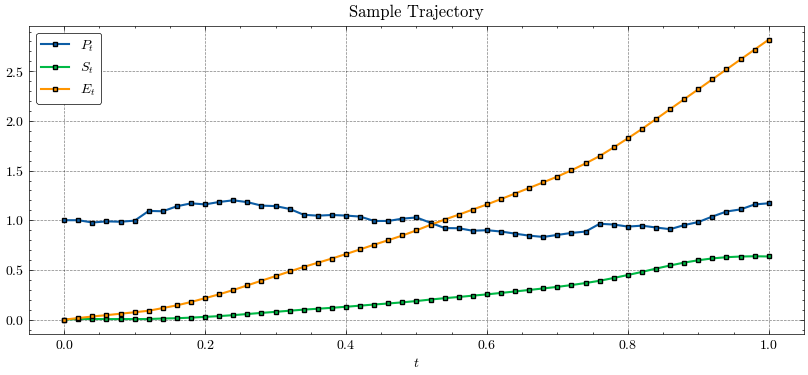

In [102]:
fig = plt.figure(figsize=(10, 4))

t = model_config["T"] / model_config["N_euler"] * np.arange(model_config["N_euler"] + 1)
plt.plot(
    t,
    P.flatten().detach().numpy(),
    label=r"$P_t$",
    marker="s",
    mec="k",
    ms=3,
    lw=1.5,
)
plt.plot(
    t, S.flatten().detach().numpy(), label=r"$S_t$", marker="s", mec="k", ms=3, lw=1.5
)
plt.plot(
    t, E.flatten().detach().numpy(), label=r"$E_t$", marker="s", mec="k", ms=3, lw=1.5
)

legend = plt.legend(fancybox=True, edgecolor="black", loc=0)
legend.get_frame().set_linewidth(0.5)
plt.title("Sample Trajectory")
plt.xlabel(r"$t$")
# fig.savefig("graphs/oil_drilling/Sample_traj_oil_N50.pdf")
plt.show()
plt.close()